## Small World Networks

CS 575
Brigham Young University
Mike Goodrich

Winter 2025

---

### Utilities used in this tutorial

Let's define functions that do the things we'll need in this tutorial.

In [89]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from numpy.typing import NDArray
from typing import Union, Hashable, Tuple

def show_graph(G: nx.Graph,
               title: str = "",
               labels: Union[dict[int, str], None] = None,
               axes: Union[None, Axes] = None
               ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    node_positions: dict[Hashable, tuple[float,float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    if axes is None:
        axes: Axes = plt.gca()
    axes.set_title(title)
    axes.set_aspect('equal')
    nx.draw(G, 
        node_positions, 
        node_color = ['y' for node in G.nodes], 
        with_labels = True, 
        labels = labels,
        node_size = 300,
        ax=axes, 
        alpha=0.8)
    plt.show()

def get_adjacency_matrix(G: Union[nx.Graph, nx.DiGraph]) -> NDArray:
    return nx.adjacency_matrix(G,nodelist=[node for node in sorted(G.nodes)]).toarray()  


---

### Definition of a small world network

Suppose we have a graph $G = \{V, E\}$. Suppose further that the graph is connected. 

Let $d(u,v)$ denote the shortest distance (number of edges) between vertex $u$ and vertex $v$. Let $\bar{d}$ denote the average distance over pairs of vertices. We're using the notation that we introduced earlier in class. 

Let $n$ denote the number of vertices in $G$.  Note that the [wikipedia entry on small world networks](https://en.wikipedia.org/wiki/Small-world_network) uses $N$ instead of $n$. 


**Computing average distance**

Let's show an example of the distance between two vertices to start building our intuition.

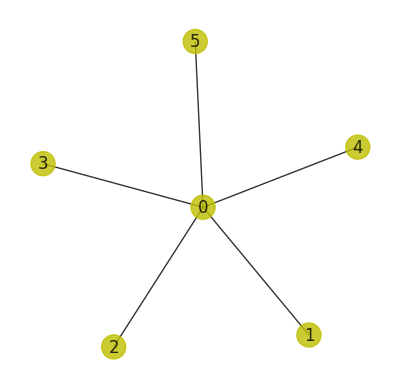

In [90]:
G = nx.star_graph(5)
show_graph(G)

The distance between vertex 0 and every other vertex is 1, and the distance between any of the other vertices is 2. We can compute this using Floyd's algorithm.

In [91]:
from scipy.sparse.csgraph import floyd_warshall
A: NDArray = get_adjacency_matrix(G)
print(A)
D: NDArray = floyd_warshall(A)
print(D)


[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
[[0. 1. 1. 1. 1. 1.]
 [1. 0. 2. 2. 2. 2.]
 [1. 2. 0. 2. 2. 2.]
 [1. 2. 2. 0. 2. 2.]
 [1. 2. 2. 2. 0. 2.]
 [1. 2. 2. 2. 2. 0.]]


The first row of the distance matrix $D$ is the distance from vertex 0 to every other vertex. As we expected, the distance from vertex $0$ to every other vertex is 1. The diagonal elements of this matrix are all 0's, which just says that the distance between a vertex and itself is 0.

We want to compute the average distance distance between vertices, but we don't want to include the distance from a vertex to itself since this is uninteresting. We can do this by hand before doing it with code, which will hopefully build some intuition.

There are $n(n-1)/2 = 6(5)/2 = 15$ unique pairs of vertices, and thus $15$ least-distance paths between each pair of vertices. (Since the graph is undirected we don't need to worry about the direction of the paths.) Five of these paths have length 1 since they involve vertex 0. The other 10 have length 2 since they don't involve vertex 0. The average is thus

$$ \bar{d} = \frac{5*1 + 10*2}{15} = 1.667$$

The code for computing the average without including the diagonals is from copilot in response to the prompt _how do i compute the average of all elements of a numpy array except for the diagonal_.

In [92]:
def get_average_sans_diagonal(M: NDArray) -> float:
    # Create a mask for the diagonal elements
    mask: NDArray = np.eye(M.shape[0], dtype=bool)

    # Use the mask to filter out the diagonal elements
    non_diagonal_elements: NDArray = M[~mask]
                                       
    # Compute the average of the non-diagonal elements
    return np.mean(non_diagonal_elements)


Let's test this for the start graph.

In [93]:
print(np.isclose((5*1+10*2)/15, get_average_sans_diagonal(D)))

True


Networkx has a function that computes this average for us. Let's check to see if it works.

In [94]:
print(nx.average_shortest_path_length(G))

1.6666666666666667


---

### Properties of a small world network

A small world network satisfies two properties (from the [wikipedia article](https://en.wikipedia.org/wiki/Small-world_network)):
- the "typical distance $L$ between two randomly chosen nodes ... grows proportionally to the logarithm of the number of nodes [$n$] in the network"
- the clustering coefficient is not small

Let's focus on the first property because its definition is subtle.

**Typical distance**

The formula that represents the statement "the typical distance $L$ between two randomly chosen nodes ... grows proportionally to the logarithm of the number of nodes [$n$] in the network" is

$$ L \propto \log n $$

The words "typical distance" sounds a lot like "average distance", which would mean that $L=\bar{d}$, but that can't be true because $\bar{d}$ is a constant for a given graph. That makes the wikipedia definition a little deceptive because it says that a small-world network is a graph. It's not a graph; **it's a family of graphs**. Let's illustrate with an example.

In the example, we'll use the `nx.newman_watts_strogatz_graph` function to construct several graphs, each of which has the same number of vertices $n$. I'll use the graph plotting routine from the graphlets tutorial.

In [95]:
def show_graphs_in_a_set(graphs: list[nx.Graph], 
                         labels: dict[Union[str, int], str] = {},
                         num_cols: int = 4) -> None:
    if num_cols < 1:
        raise ValueError 
    colors: list[str] = ['y', 'lightblue', 'lightgray', 'salmon', 
                         'aquamarine', 'lightpink', 'violet', 'linen']

    num_cols: int = min(num_cols, len(graphs)) # no more columns than graphlets
    num_rows: int = int(np.ceil(len(graphs)/num_cols))
    _, axs = plt.subplots(num_rows, num_cols, 
                          figsize = (2*num_cols, 2*num_rows))
    
    for count in range(num_rows * num_cols):
        ### Choose the right axis format depending on how many graphs there are to plot
        if num_rows == 1 and num_cols == 1:
            axis = plt.gca()
        elif num_rows == 1 and num_cols > 1:
            col = count%num_cols
            axis = axs[col]
        else:
            col = count%num_cols
            row = int(np.floor(count/num_cols))
            axis = axs[row,col]
        
        ### If there are more spots in the grid layout than there are graphs then make some blank
        if count >= len(graphs):
            axis.set_visible(False)
            continue

        ### Choose a circular layout because that makes it easy to see the nodes and edges for small graphs
        pos = nx.circular_layout(graphs[count])
        
        if len(labels) == 0:
            nx.draw(graphs[count], 
                        pos,
                        ax=axis, 
                        node_color=colors[count%len(colors)], 
                        alpha = 0.8, 
                        node_size = 300)
        else:
            sublabels = {node: label for node, label in labels.items() if node in graphs[count].nodes() }
            nx.draw(graphs[count], 
                        pos,
                        ax=axis, 
                        node_color=colors[count%len(colors)], 
                        alpha = 0.8, 
                        node_size = 300,
                        labels = sublabels)
            #sublabels = {node: label for node, label in labels.items() if node in graphs[count].nodes() }
            #nx.draw_networkx_labels(graphs[count], pos, sublabels, font_size=12)
        axis.set_xlim(-1.2, 1.2)
        axis.set_ylim(-1.2, 1.2)
        axis.set_aspect('equal')

For 10 graphs with 10 vertices, L(10) = 1.4 


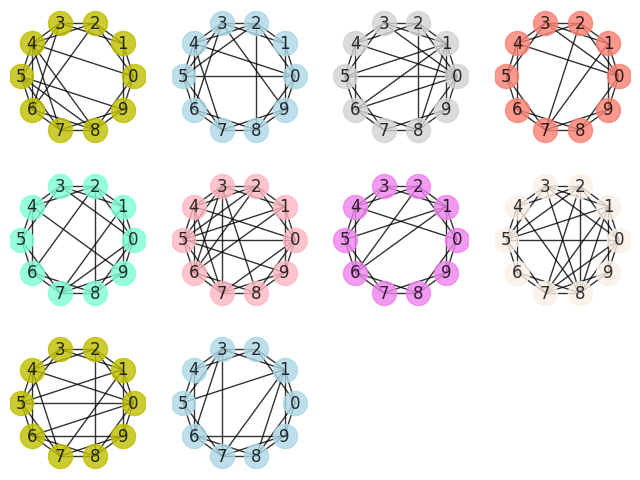

In [99]:
number_vertices: list[int] = [10]
average_distances_dict: dict[int, list[float]] = {n: [] for n in number_vertices}
L_dict: dict[int, list[float]] = dict()
number_graphs_per_vertex_number = 10
graph_list: list[nx.Graph] = []
for n in number_vertices:
    average_distances: list[float] = []
    for _ in range(number_graphs_per_vertex_number):
        G: nx.Graph = nx.newman_watts_strogatz_graph(n, 4, .3)
        graph_list.append(G)
        average_distances_dict[n].append(nx.average_shortest_path_length(G))
    show_graphs_in_a_set(graph_list,
                         labels = {node: str(node) for node in G.nodes})
    L_dict[n] = np.mean(average_distances_dict[n])
_ = [print(f"For {number_graphs_per_vertex_number} graphs with {n} vertices, L({n}) = {np.round(L,2)} ") for n, L in L_dict.items()]


Repeat for graphs with different numbers of nodes

For 10 graphs with 8 vertices, L(8) = 1.27 


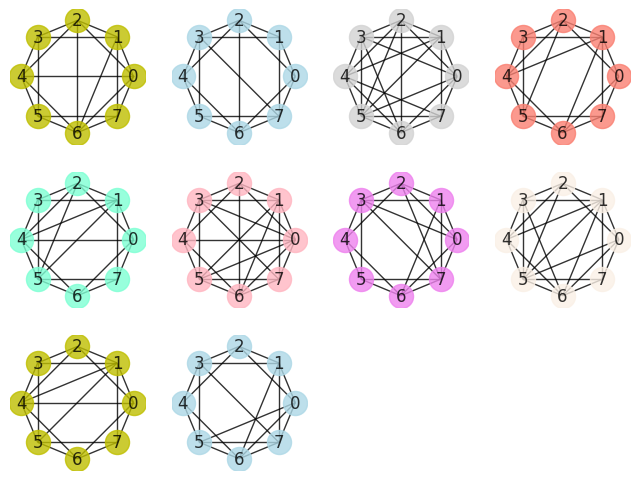

In [101]:
number_vertices: list[int] = [8]
average_distances_dict: dict[int, list[float]] = {n: [] for n in number_vertices}
L_dict: dict[int, list[float]] = dict()
number_graphs_per_vertex_number = 10
graph_list: list[nx.Graph] = []
for n in number_vertices:
    average_distances: list[float] = []
    for _ in range(number_graphs_per_vertex_number):
        G: nx.Graph = nx.newman_watts_strogatz_graph(n, 4, .3)
        graph_list.append(G)
        average_distances_dict[n].append(nx.average_shortest_path_length(G))
    show_graphs_in_a_set(graph_list,
                         labels = {node: str(node) for node in G.nodes})
    L_dict[n] = np.mean(average_distances_dict[n])
_ = [print(f"For {number_graphs_per_vertex_number} graphs with {n} vertices, L({n}) = {np.round(L,2)} ") for n, L in L_dict.items()]

 We'll construct a dictionary indexed by the number of vertices in a graph, and then build a handful of graphs with that number of vertices. We'll compute the $\bar{d}(G)$ for each graph and then average the average distances together. 

In [68]:
number_vertices: list[int] = [20, 30, 40, 50, 60, 70, 80, 90, 100]
average_distances_dict: dict[int, list[float]] = {n: [] for n in number_vertices}
L_dict: dict[int, list[float]] = dict()

number_graphs_per_vertex_number = 10
for n in number_vertices:
    average_distances: list[float] = []
    for _ in range(number_graphs_per_vertex_number):
        G: nx.Graph = nx.newman_watts_strogatz_graph(n, 4, .3)
        average_distances_dict[n].append(nx.average_shortest_path_length(G))
    L_dict[n] = np.mean(average_distances_dict[n])
_ = [print(f"For {number_graphs_per_vertex_number} graphs with {n} vertices, L({n}) = {np.round(L,2)} ") for n, L in L_dict.items() ]


For 10 graphs with 20 vertices, L(20) = 2.0 
For 10 graphs with 30 vertices, L(30) = 2.36 
For 10 graphs with 40 vertices, L(40) = 2.67 
For 10 graphs with 50 vertices, L(50) = 2.73 
For 10 graphs with 60 vertices, L(60) = 2.97 
For 10 graphs with 70 vertices, L(70) = 3.09 
For 10 graphs with 80 vertices, L(80) = 3.2 
For 10 graphs with 90 vertices, L(90) = 3.3 
For 10 graphs with 100 vertices, L(100) = 3.4 


Let's plot the results using a logarithmic scale for the x-axis.

{20: np.float64(2.0026315789473688), 30: np.float64(2.3583908045977013), 40: np.float64(2.6656410256410257), 50: np.float64(2.7282448979591836), 60: np.float64(2.9692090395480224), 70: np.float64(3.087370600414079), 80: np.float64(3.1975632911392404), 90: np.float64(3.303270911360799), 100: np.float64(3.3955757575757572)}


Text(0, 0.5, 'L(n)')

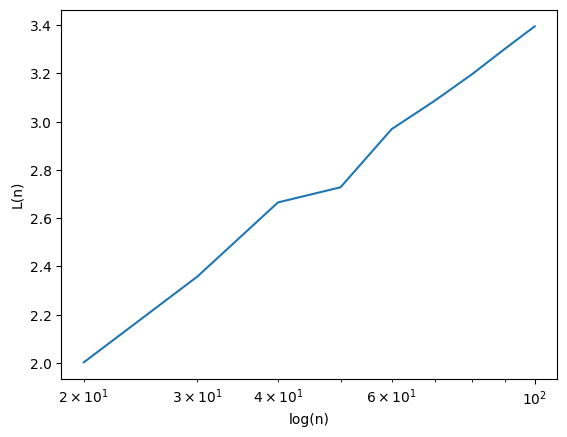

In [69]:
print(L_dict)
plt.semilogx(L_dict.keys(), L_dict.values())
plt.xlabel('log(n)')
plt.ylabel('L(n)')